In [12]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import numpy.random as rand
import pickle
import NSMap as ns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import adfuller
import matplotlib.gridspec as gridspec

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Round 2 
Here we assess how performance of the method is impacted by time series length, amount of observation noise, and amount of process noise for the Logistic Map and Food Chain systems.

You may skip ahead to the figure generation section and use pre-run simulation results to make the figure. Or, you may run the below code which executes the simulations and overwrites the previous simulation results (this takes a while).

### Process Noise Parameter Determination
But first, we determine empirically the amount of process noise to introduce into the Logistic Map and Food Chain systems so that their variance increases by 10%. Uncomment the below code to produce a new estimate, will be very close to the value hard-coded.

In [13]:
## LOGISTIC MAP ##
"""
compute_logistic_variance = lambda p : np.mean(np.array([
                            np.var(generateLogisticMapProcessNoise(
                            process_noise = p, r=lambda t: 3.75,
                            x0 = rand.rand(1)[0]))
                            for _ in range(100)]))

logistic_null_variance = compute_logistic_variance(0)

pn = np.linspace(0,1,num=50)
varratios = np.array([compute_logistic_variance(p) / 
                      logistic_null_variance 
                      for p in pn])

logistic_process_noise = (pn[varratios > 1.1])[0]
"""

'\ncompute_logistic_variance = lambda p : np.mean(np.array([\n                            np.var(generateLogisticMapProcessNoise(\n                            process_noise = p, r=lambda t: 3.75,\n                            x0 = rand.rand(1)[0]))\n                            for _ in range(100)]))\n\nlogistic_null_variance = compute_logistic_variance(0)\n\npn = np.linspace(0,1,num=50)\nvarratios = np.array([compute_logistic_variance(p) / \n                      logistic_null_variance \n                      for p in pn])\n\nlogistic_process_noise = (pn[varratios > 1.1])[0]\n'

In [14]:
# FINAL VALUE 

logistic_process_noise = 0.26530612244897955

In [15]:
## FOOD CHAIN ##
"""
compute_food_chain_variance = lambda p : np.var(
                                [generateTimeSeriesContinuous(
                                    'HastingsPowellP', x0 + rand.random(3) * 0.1,
                                    nsargs=(lambda t: 3,), end=200*8,
                                    tlen = 200, reduction = reduction,
                                    settlingTime=settlingTime,
                                    process_noise=p)[:,0,None]
                                for _ in range(100)])

food_chain_null_variance = compute_food_chain_variance(0)

pn = np.linspace(0,0.05,num=20)
ratios = np.array([compute_food_chain_variance(p) / 
                   food_chain_null_variance 
                   for p in pn])

food_chain_process_noise = (pn[ratios > 1.1])[0]
"""

"\ncompute_food_chain_variance = lambda p : np.var(\n                                [generateTimeSeriesContinuous(\n                                    'HastingsPowellP', x0 + rand.random(3) * 0.1,\n                                    nsargs=(lambda t: 3,), end=200*8,\n                                    tlen = 200, reduction = reduction,\n                                    settlingTime=settlingTime,\n                                    process_noise=p)[:,0,None]\n                                for _ in range(100)])\n\nfood_chain_null_variance = compute_food_chain_variance(0)\n\npn = np.linspace(0,0.05,num=20)\nratios = np.array([compute_food_chain_variance(p) / \n                   food_chain_null_variance \n                   for p in pn])\n\nfood_chain_process_noise = (pn[ratios > 1.1])[0]\n"

In [16]:
# FINAL VALUE

food_chain_process_noise = 0.018421052631578946

# Process Noise Parameter Determination

In [17]:
# General Hyperparameters
N_replicates = 1
reduction = 2 ** 8
settlingTime = 200
E_max = 5
tau = 1

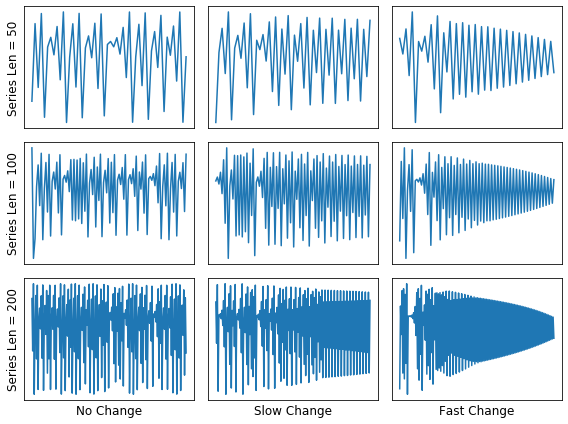

In [18]:
# Time Series Length versus Nonstationarity Rate
T_list = (50, 100, 200)
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.25 * t, lambda t: 3.75 - 0.75 * t)
ns_status = ["No Change", "Slow Change", "Fast Change"]

# Time Series Length, nonstationarity status, delta, theta, r_sqrd
results = np.zeros((N_replicates * len(T_list) * len(r_list), 5))
results_index = 0

fig, ax = plt.subplots(3,3,figsize=(8,6), tight_layout=True)

for ti, T in enumerate(T_list):
    for ri, r in enumerate(r_list):
        for i in range(N_replicates):
            x0 = rand.rand(1)
            Xr = ns.standardize(ns.generateLogisticMapProcessNoise(tlen = T, r = r, x0 = x0))

            if i == 0:
                ax[ti, ri].plot(np.linspace(0,1,num=T), Xr)
                ax[ti, ri].set_xticks([])
                ax[ti, ri].set_yticks([])

            """
            delta_agg, theta_agg, r_sqrd = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True)

            results[results_index] = np.array([T, ri, delta_agg, theta_agg, r_sqrd])
            results_index += 1
            
np.savetxt(f"../results/round2_results/logistic_T_vs_NS_Rate.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")
"""
for i in range(3):
    ax[i,0].set_ylabel(r"Series Len = {}".format(T_list[i]), rotation=90,
                     fontsize=12)
    ax[2,i].set_xlabel(r"{}".format(ns_status[i]), fontsize=12)
plt.savefig("../figures_eps/example_series/Figure_S3.eps", format="eps", bbox_inches="tight")

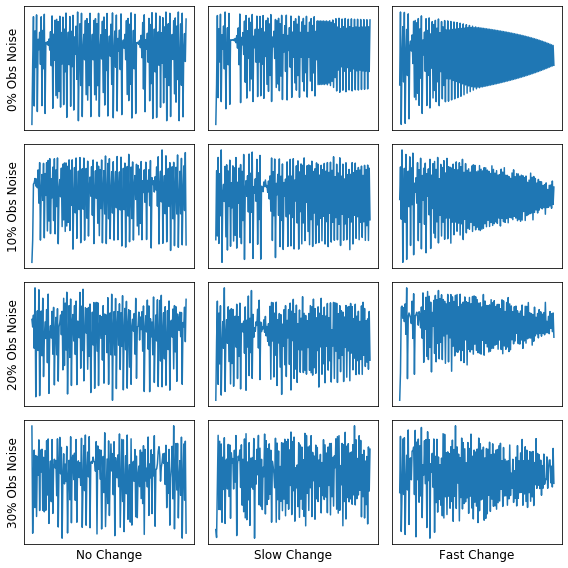

In [19]:
# Observation Noise versus Nonstationarity Rate
T = 200
obs_list = (0.0,0.1,0.2,0.3)
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.25 * t, lambda t: 3.75 - 0.75 * t)

# observation noise, nonstationarity status, delta, theta, r_sqrd
results = np.zeros((N_replicates * len(obs_list) * len(r_list), 5))
results_index = 0

fig, ax = plt.subplots(4,3,figsize=(8,8), tight_layout=True)

for oi, o_n in enumerate(obs_list):
    for ri, r in enumerate(r_list):
        for i in range(N_replicates):
            x0 = rand.rand(1)
            Xr = ns.standardize(ns.generateLogisticMapProcessNoise(r=r, x0 = x0))
            Xr += (rand.normal(0, o_n, T))[:,None]
            
            if i == 0:
                ax[oi, ri].plot(np.linspace(0,1,num=T), Xr)
                ax[oi, ri].set_xticks([])
                ax[oi, ri].set_yticks([])
            
            """
            delta_agg, theta_agg, r_sqrd = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True)
            
            results[results_index] = np.array([o_n, ri, delta_agg, theta_agg, r_sqrd])
            results_index += 1
            
np.savetxt(f"../results/round2_results/logistic_obsnoise_vs_NS_Rate.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")
"""
for i in range(4):
    ax[i,0].set_ylabel(r"{}% Obs Noise".format(["0","10","20","30"][i]), rotation=90,
                     fontsize=12)
for i in range(3):
    ax[3,i].set_xlabel(r"{}".format(ns_status[i]), fontsize=12)
plt.savefig("../figures_eps/example_series/Figure_S4.eps", format="eps", bbox_inches="tight")

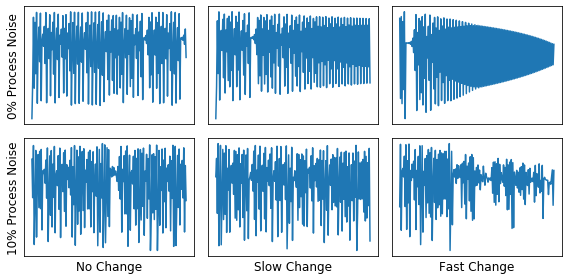

In [20]:
# Process Noise versus Nonstationarity Rate
T = 200
pro_list = (0.0, logistic_process_noise)
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.25 * t, lambda t: 3.75 - 0.75 * t)

# process noise, nonstationarity status, delta, theta, r_sqrd
results = np.zeros((N_replicates * len(pro_list) * len(r_list), 5))
results_index = 0

fig, ax = plt.subplots(2,3,figsize=(8,4), tight_layout=True)

for pi, p_n in enumerate(pro_list):
    for ri, r in enumerate(r_list):
        for i in range(N_replicates):
            x0 = rand.rand(1)
            Xr = ns.standardize(ns.generateLogisticMapProcessNoise(
                             process_noise = p_n, r=r, x0 = x0))
        
            if i == 0:
                ax[pi, ri].plot(np.linspace(0,1,num=T), Xr)
                ax[pi, ri].set_xticks([])
                ax[pi, ri].set_yticks([])
            """
            delta_agg, theta_agg, r_sqrd = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True)
            
            results[results_index] = np.array([p_n, ri, delta_agg, theta_agg, r_sqrd])
            results_index += 1
            
np.savetxt(f"../results/round2_results/logistic_pronoise_vs_NS_Rate.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")
"""
for i in range(2):
    ax[i,0].set_ylabel(r"{}% Process Noise".format(["0", "10"][i]), rotation=90,
                     fontsize=12)
for i in range(3):
    ax[1,i].set_xlabel(r"{}".format(ns_status[i]), fontsize=12)
plt.savefig("../figures_eps/example_series/Figure_S5.eps", format="eps", bbox_inches="tight")

# Food Chain

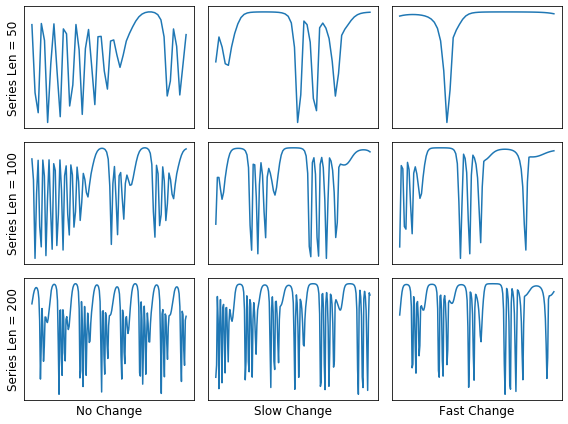

In [21]:
# Time Series Length versus Nonstationarity Rate
T_list = (50, 100, 200)
b1_list = (lambda t: 3, lambda t: 3 + 2 * t / end, lambda t: 3 + 4 * t / end)

# Time Series Length, nonstationarity status, delta, theta, r_sqrd
results = np.zeros((N_replicates * len(T_list) * len(b1_list), 5))
results_index = 0

fig, ax = plt.subplots(3,3,figsize=(8,6), tight_layout=True)

for ti, T in enumerate(T_list):
    end = T * 5
    
    for b1i, b1 in enumerate(b1_list):
        for i in range(N_replicates):
            
            
            x0 = np.array([0.1,0.4,9]) + rand.random(3)
            Xr = ns.standardize(ns.generateTimeSeriesContinuous('FoodChainP',
                                        x0, end=end, tlen = T, nsargs=(b1,), 
                                        reduction = reduction, settlingTime=settlingTime, 
                                        process_noise=0)[:,0,None])
    
            if i == 0:
                ax[ti, b1i].plot(np.linspace(0,1,num=T), Xr)
                ax[ti, b1i].set_xticks([])
                ax[ti, b1i].set_yticks([])
            """
            delta_agg, theta_agg, r_sqrd = ns.get_delta_agg(Xr, E_max, tau=tau, return_forecast_skill=True)
            
            results[results_index] = np.array([T, b1i, delta_agg, theta_agg, r_sqrd])
            results_index += 1
            
np.savetxt(f"../results/round2_results/food_chain_T_vs_NS_Rate.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")
"""
for i in range(3):
    ax[i,0].set_ylabel(r"Series Len = {}".format(T_list[i]), rotation=90,
                     fontsize=12)
    ax[2,i].set_xlabel(r"{}".format(ns_status[i]), fontsize=12)
plt.savefig("../figures_eps/example_series/Figure_S6.eps", format="eps", bbox_inches="tight")

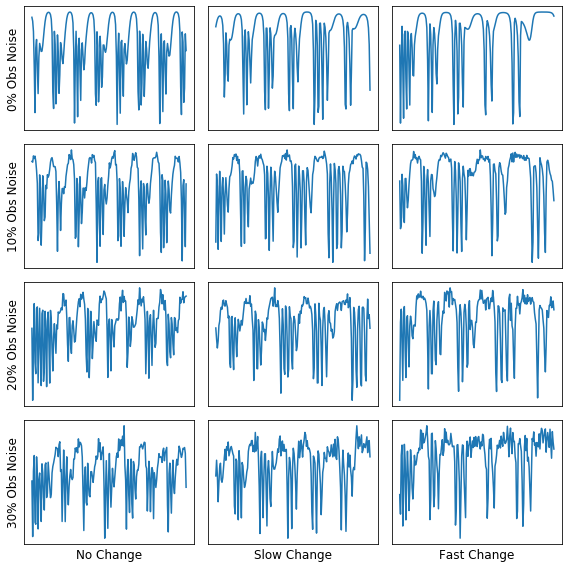

In [22]:
# Observation Noise versus Nonstationarity Rate
T = 200
end = T * 5

obs_list = (0.0,0.1,0.2,0.3)
b1_list = (lambda t: 3, lambda t: 3 + 2 * t / end, lambda t: 3 + 4 * t / end)

# log_std is calculated as the standard deviation on a stationary hastings powell map series with T=200 and b1=3
log_std = 0.20682984252169215

# observation noise, nonstationarity status, delta, theta, r_sqrd
results = np.zeros((N_replicates * len(obs_list) * len(b1_list), 5))
results_index = 0

fig, ax = plt.subplots(4,3,figsize=(8,8), tight_layout=True)

for oi, o_n in enumerate(obs_list):
    for b1i, b1 in enumerate(b1_list):
        for i in range(N_replicates):
            x0 = np.array([0.1,0.4,9]) + rand.random(3)
            Xr = ns.standardize(ns.generateTimeSeriesContinuous('FoodChainP', x0, end=end, tlen = T, nsargs=(b1,), 
                                              reduction = reduction, settlingTime=settlingTime, 
                                              process_noise=0)[:,0,None])
            Xr += (rand.normal(0, o_n, T))[:,None]
            
            if i == 0:
                ax[oi, b1i].plot(np.linspace(0,1,num=T), Xr)
                ax[oi, b1i].set_xticks([])
                ax[oi, b1i].set_yticks([])
            """
            delta_agg, theta_agg, r_sqrd = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True)
            
            results[results_index] = np.array([o_n, b1i, delta_agg, theta_agg, r_sqrd])
            results_index += 1
            
np.savetxt(f"../results/round2_results/food_chain_obsnoise_vs_NS_Rate.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")
"""
for i in range(4):
    ax[i,0].set_ylabel(r"{}% Obs Noise".format([0,10,20,30][i]), rotation=90,
                     fontsize=12)
for i in range(3):
    ax[3,i].set_xlabel(r"{}".format(ns_status[i]), fontsize=12)
plt.savefig("../figures_eps/example_series/Figure_S7.eps", format="eps", bbox_inches="tight")

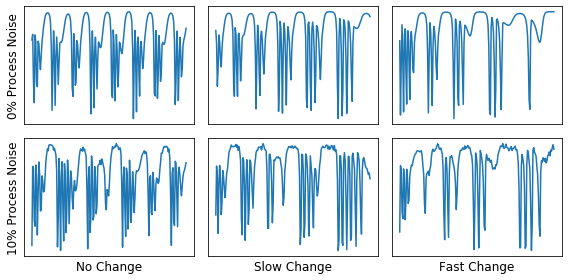

In [23]:
# Process Noise versus Nonstationarity Rate
T = 200
end = T * 5

pro_list = (0.0, 0.017)
b1_list = (lambda t: 3, lambda t: 3 + 2 * t / end, lambda t: 3 + 4 * t / end)

fig, ax = plt.subplots(2,3,figsize=(8,4), tight_layout=True)

# process noise, nonstationarity status, delta, theta, r_sqrd
results = np.zeros((N_replicates * len(pro_list) * len(b1_list), 5))
results_index = 0

for pi, p_n in enumerate(pro_list):
    for b1i, b1 in enumerate(b1_list):
        for i in range(N_replicates):
            x0 = np.array([0.1,0.4,9]) + rand.random(3)
            Xr = ns.standardize(ns.generateTimeSeriesContinuous('FoodChainP', x0, end=end, tlen = T, nsargs=(b1,), 
                                              reduction = reduction, settlingTime=settlingTime, 
                                              process_noise=p_n)[:,0,None])
            
            if i == 0:
                ax[pi, b1i].plot(np.linspace(0,1,num=T), Xr)
                ax[pi, b1i].set_xticks([])
                ax[pi, b1i].set_yticks([])
            """
            delta_agg, theta_agg, r_sqrd = ns.get_delta_agg(Xr, E_max, return_forecast_skill=True)
            
            results[results_index] = np.array([p_n, b1i, delta_agg, theta_agg, r_sqrd])
            results_index += 1
            
np.savetxt(f"../results/round2_results/food_chain_pronoise_vs_NS_Rate.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")
"""
for i in range(2):
    ax[i,0].set_ylabel(r"{}% Process Noise".format(["0", "10"][i]), rotation=90,
                     fontsize=12)
for i in range(3):
    ax[1,i].set_xlabel(r"{}".format(ns_status[i]), fontsize=12)

plt.savefig("../figures_eps/example_series/Figure_S8.eps", format="eps", bbox_inches="tight")

# Round 2 Results (Figure 4)
This figure emulates the version found in the chaos paper, which encodes many dimensions as a grid of heatmaps.

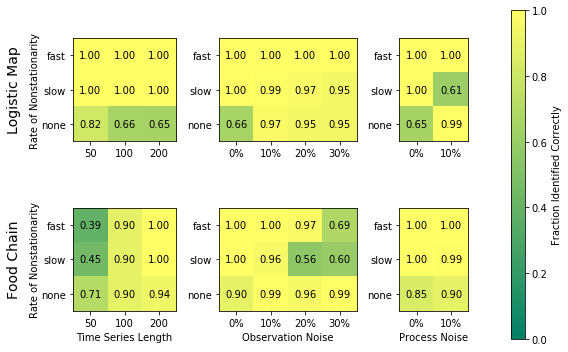

In [9]:
fig = plt.figure(tight_layout=True,figsize=(8,5))
shrink = 0.8
grid = gridspec.GridSpec(2,4, width_ratios=[3,4,2,0.4])
nice_variable_names = ["Time Series Length", "Observation Noise","Process Noise"]
nice_model_names = ["Logistic Map", "Food Chain"]
# fig, ax = plt.subplots(2,3)
# plt.tight_layout()

for i, model in enumerate(["logistic", "food_chain"]):
    for j, variable in enumerate(["T","obsnoise","pronoise"]):
        filename = f"../results/round2_results/{model}_{variable}_vs_NS_Rate.csv"
        table = np.loadtxt(filename, delimiter=",")
        
        # observation noise, nonstationarity status, delta, theta, r_sqrd
        variables = np.unique(table[:,0])
        heatmap = np.zeros((3,len(variables)))

        ax = fig.add_subplot(grid[i,j]) if j < 2 else fig.add_subplot(grid[i,2:3])
        
        for k, val in enumerate(variables):
            for nsrate in range(3):
                accuracy = np.mean(table[np.logical_and(table[:,0] == val,table[:,1] == nsrate),2] > 0.1)
                accuracy = accuracy if nsrate else 1 - accuracy
                heatmap[nsrate,k] = accuracy
                ax.text(k,nsrate,f"{accuracy:.2f}",ha='center',va='center')
        
        aximage = ax.imshow(heatmap,vmin=0,vmax=1,cmap='summer')
        left, right, _, _ = aximage.get_extent()
        
        ax.set_xticks(np.arange(len(variables)))
        if j == 0:
            ax.set_xticklabels(variables.astype(int))
        elif j == 1:
            ax.set_xticklabels(np.array(["0%","10%","20%","30%"]))
        else:
            ax.set_xticklabels(np.array(["0%","10%"]))
        if model == "food_chain":
            ax.set_xlabel(nice_variable_names[j])
        ax.set_yticks(np.arange(3))
        ax.set_yticklabels(["none","slow","fast"])
        ax.set_ylim([-0.5,2.5])
        
        if (j == 0):
            # ax.set_ylabel(nice_model_names[i], labelpad=25, fontsize=12)
            ax.set_ylabel(nice_model_names[i], labelpad = 20, fontsize=14)
            fig.text(-0.325, 0.5, "Rate of Nonstationarity", rotation="vertical", transform=ax.transAxes,
                              horizontalalignment="right", verticalalignment="center")
            
# fig.text(0.07,0.5375,"Rate of Nonstationarity", rotation="vertical",
#          horizontalalignment="center", verticalalignment="center", size=12 )
# plt.tight_layout()
# cax = plt.axes([0.905, 0.09, 0.02, 0.845])
# fig.colorbar(aximage, cax = cax, label = "Fraction Identified Correctly")
colorbar_ax = fig.add_subplot(grid[:,3])
fig.colorbar(aximage, cax = colorbar_ax, 
             label = "Fraction Identified Correctly", 
             shrink=0.1, anchor=(1000,1))
# plt.savefig("../Figures/round2.png", dpi=300)
plt.savefig("../figures_eps/round2_results/Figure_4.eps", format="eps", bbox_inches="tight")